- On all 3 VMs we created a conda enviroment and installed the same versions of all needed libraries.
- On VM1 we also installed Jupyter-notebook

In [1]:
import dask.array as da
from dask.distributed import Client
from dask.distributed import performance_report
from dask_ml.preprocessing import StandardScaler
from dask_ml.cluster import KMeans
import numpy as np
from dask_ml.metrics import pairwise_distances, pairwise_distances_argmin_min
from time import time
from timeit import default_timer as now
from dask_ml.datasets import make_blobs
import pandas as pd
from dask.distributed import SSHCluster
import matplotlib.pyplot as plt
import getpass
from sklearn.datasets import fetch_kddcup99
from itertools import product
from tqdm.auto import tqdm
import pickle, pathlib

## Functions

In [2]:
def total_min_distance(data, centroids):
    distances = pairwise_distances(data, centroids, metric='sqeuclidean')
    return distances.min(axis=1).sum().compute()

def initial_candidate_selection(data, num_clusters, oversampling_factor):
    num_points, _ = data.shape
    seed_idx = np.random.choice(num_points, size=1)
    centroid_pool = data[seed_idx].compute()

    init_cost = total_min_distance(data, centroid_pool)
    num_rounds = int(np.log(init_cost + 1e-6))  # Avoid log(0)

    for _ in range(num_rounds):
        dist_sq = pairwise_distances(data, centroid_pool, metric='sqeuclidean').min(axis=1)
        prob_dist = (oversampling_factor * dist_sq / dist_sq.sum()).compute()
        #random_values = da.random.random(size=len(prob_dist), chunks=prob_dist.chunks)
        
        chunk_size = int(np.ceil(len(prob_dist) / 12))
        random_values = da.random.random(size=len(prob_dist), chunks=(chunk_size,))
        
        selected_mask = random_values < prob_dist
        selected_indices = da.where(selected_mask)[0].compute()
        new_centroids = data[sorted(selected_indices)].compute()
        centroid_pool = np.vstack([centroid_pool, new_centroids])

    return centroid_pool

def compute_assignment_weights(data, centroids):
    distances = pairwise_distances(data, centroids, metric='euclidean')
    closest_indices = da.argmin(distances, axis=1)
    counts = da.bincount(closest_indices, minlength=len(centroids)).compute()
    weight_sum = counts.sum()
    if weight_sum == 0:
        return np.ones(len(centroids)) / len(centroids)
    cluster_weights = counts / weight_sum
    return cluster_weights

def kmeans_plus_plus_weighted_init(data, cluster_weights, num_clusters):
    num_points, _ = data.shape
    seed_idx = np.random.choice(num_points, size=1)
    centers = data[seed_idx].compute()

    for _ in range(1, num_clusters):
        dist_sq = pairwise_distances(data, centers, metric='sqeuclidean').min(axis=1) * cluster_weights
        prob = dist_sq / dist_sq.sum()
        new_idx = np.random.choice(num_points, size=1, p=prob.compute())
        new_center = data[sorted(new_idx)].compute()
        centers = np.vstack([centers, new_center])

    return centers

def assign_to_centroids(data, centers):
    cluster_labels, _ = pairwise_distances_argmin_min(data, centers, metric='sqeuclidean')
    return cluster_labels

def weighted_centroid_update(data, cluster_labels, cluster_weights, num_clusters):
    updated = []
    for cluster_id in range(num_clusters):
        cluster_mask = cluster_labels == cluster_id
        cluster_data = data[cluster_mask]
        weight_subset = cluster_weights[cluster_mask]
        if cluster_data.shape[0] == 0:
            continue
        cluster_mean = da.average(cluster_data, axis=0, weights=weight_subset)
        updated.append(cluster_mean)
    return da.stack(updated)

def run_lloyds(data, cluster_weights, num_clusters, max_iter=100, tolerance=1e-8):
    centroids = kmeans_plus_plus_weighted_init(data, cluster_weights, num_clusters)

    for _ in range(max_iter):
        cluster_labels = assign_to_centroids(data, centroids).compute()
        new_centroids = weighted_centroid_update(data, cluster_labels, cluster_weights, num_clusters).compute()
        if da.allclose(new_centroids, centroids, atol=tolerance).compute():
            break
        centroids = new_centroids
    return cluster_labels, centroids

def run_distributed_kmeans(data, num_clusters, max_iter=100, tolerance=1e-8, oversample_factor=2):
    candidate_centroids = initial_candidate_selection(data, num_clusters, oversample_factor)
    cluster_weights = compute_assignment_weights(data, candidate_centroids)
    dask_centroids = da.from_array(candidate_centroids, chunks=(candidate_centroids.shape[0], candidate_centroids.shape[1]))
    cluster_labels, centroids = run_lloyds(dask_centroids, cluster_weights, num_clusters, max_iter, tolerance)
    
    for _ in range(max_iter):
        cluster_labels = assign_to_centroids(data, centroids)
        new_centroids = da.stack([data[cluster_labels == i].mean(axis=0) for i in range(num_clusters)]).compute()
        if da.allclose(centroids, new_centroids, atol=tolerance).compute():
            break
        centroids = new_centroids

    return cluster_labels, centroids

## Synthetic data test

In [ ]:
hosts = [
    "10.67.22.199",
    "10.67.22.199",   # VM 1  – will run the scheduler *and* a worker
    "10.67.22.138",   # VM 2  – workers only
    "10.67.22.85"    # VM 3  – workers only
]
cluster = SSHCluster(
        hosts,
        connect_options={
            "username": "ungureanu",       # SSH user on all three VMs
            "password": getpass.getpass("SSH password:"),
            "known_hosts": None,
        },
        remote_python="/opt/miniconda3/envs/dask-env/bin/python", 
        scheduler_options={
            "port": 8786,
            "dashboard_address":":8787",
        },
        worker_options={
            "n_workers": 1,        
            "nthreads": 4,      
            "memory_limit": "7.8GB"
        },
        
    )
    
client = Client(cluster)
client

In [ ]:
scheduler_info = client.scheduler_info()
workers_info = scheduler_info['workers'] 
worker = list(workers_info.values())[0]
n_workers = len(workers_info)
n_threads = worker['nthreads']

print(f'client dashboard link: {client.dashboard_link}')
print(f"Cluster setup with {n_workers} workers, each with {n_threads} threads")

Cluster setup with 3 workers, each with 4 threads

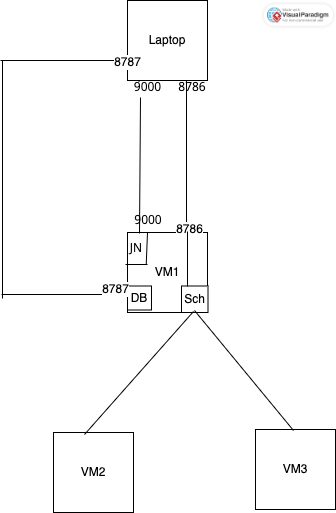

In [ ]:
n_samples = 5000000*2.5
n_features = 50
centers = 5
random_state = 42
chunks = (n_samples//23,n_features) 
synt_data, true_labels = make_blobs(n_samples=n_samples, n_features=n_features, 
                               centers=centers, chunks=chunks)
synt_data

In [ ]:
scaler = StandardScaler(with_mean=True) # for scaling with a sparse matrix
%time synt_normalized = scaler.fit_transform(synt_data)
del synt_data

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

subset = int(synt_normalized.shape[0]/10000)

# Kmeans labels plot
ax[0].scatter(synt_normalized[:subset, 0], synt_normalized[:subset, 1], c=synt_labels[:subset], cmap='viridis')
ax[0].scatter(synt_centroids[:, 0], synt_centroids[:, 1], c='red', marker='x', s=100)
ax[0].set_title('K-means clustering with Dask')

# True labels plot
ax[1].scatter(synt_normalized[:subset, 0], synt_normalized[:subset, 1], c=true_labels[:subset], cmap='viridis')
ax[1].scatter(synt_centroids[:, 0], synt_centroids[:, 1], c='red', marker='x', s=100)
ax[1].set_title('True labels')

plt.show()

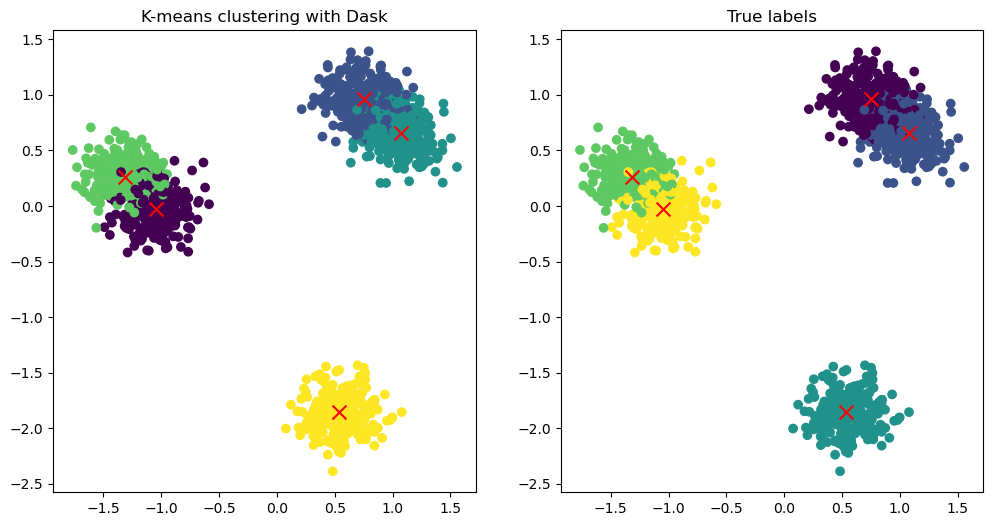

In [ ]:
cluster.close()
client.close()

## KDDCUP dataset performance benchmarking

he KDD Cup '99 dataset is a popular benchmark dataset for intrusion detection systems. It contains a vast amount of network traffic data, including simulated attacks, and is used to train and evaluate intrusion detection models.

In [ ]:

raw_data = pd.read_csv('kddcup.data.gz', header=None, compression='gzip')
exclude_indices = [1, 2, 3, 41]

numerical_data = raw_data.drop(columns=raw_data.columns[exclude_indices])

total_entries = numerical_data.shape[0]
sample_fraction = 0.8  
sample_count = int(sample_fraction * total_entries)

subset = numerical_data.iloc[:sample_count]

data = subset.to_numpy()

del raw_data, numerical_data, subset


In [ ]:
def evaluate_kmeans_performance(dataset, num_workers, threads_per_node, mem_cap, chunk_spec, repetitions):
    vm_ips = [
        "10.67.22.199",  # Acts as scheduler and worker
        "10.67.22.199",
        "10.67.22.138",
        "10.67.22.85"
    ]

    ssh_creds = {
        "username": "ungureanu",
        "password": getpass.getpass("SSH password:"),
        "known_hosts": None
    }

    cluster = SSHCluster(
        hosts=vm_ips,
        connect_options=ssh_creds,
        remote_python="/opt/miniconda3/envs/dask-env/bin/python",
        scheduler_options={
            "port": 8786,
            "dashboard_address": ":8787",
        },
        worker_options={
            "n_workers": num_workers,
            "nthreads": threads_per_node,
            "memory_limit": mem_cap
        }
    )

    client = Client(cluster)
    print(client)
    print(f"\nRunning benchmark: workers={num_workers}, threads={threads_per_node}, "
          f"memory={mem_cap}, chunks={chunk_spec}")

    
    chunked_data = da.from_array(dataset, chunks=(dataset.shape[0] // chunk_spec, dataset.shape[1]))

   
    normalizer = StandardScaler(with_mean=True)
    processed_data = normalizer.fit_transform(chunked_data)
    del chunked_data  # Free memory

    processed_data = processed_data.persist()  

    n_clusters = 4

    timing = []
    for _ in range(repetitions):
        tic = now()
        labels, centroids = run_distributed_kmeans(processed_data, n_clusters, 2)
        toc = now()
        timing.append(toc - tic)

    mean_time = np.mean(timing)
    std_time = np.std(timing)


    print(f"KMeans Avg: {mean_time:.2f}s ± {std_time:.2f}s")

    summary = {
        'workers': num_workers,
        'threads': threads_per_node,
        'memory_limit': mem_cap,
        'chunks': chunk_spec,
        'kmeans_mean_time': mean_time,
        'kmeans_std_time': std_time
    }

    client.close()
    cluster.close()

    return summary


In [ ]:
configurations = [
    {'workers': 1, 'threads': 4, 'mem': '7 GB'},    
    {'workers': 2, 'threads': 2, 'mem': '3.5 GB'}, 
    {'workers': 1, 'threads': 2, 'mem': '7 GB'},   
    {'workers': 2, 'threads': 1, 'mem': '3.5 GB'},  
    {'workers': 1, 'threads': 3, 'mem': '7 GB'},    
]

chunk_options = [4, 6, 8, 10, 16]

out_dir = pathlib.Path("bench_runs")
out_dir.mkdir(exist_ok=True)

for cfg, chunks in product(configurations, chunk_options):
    output = evaluate_kmeans_performance(
        dataset=data,
        num_workers=cfg["workers"],
        threads_per_node=cfg["threads"],
        mem_cap=cfg["mem"],
        chunk_spec=chunks,
        repetitions=3,
    )
    output.update(cfg, chunks=chunks)

    stamp = int(time() * 1000)         
    fname = f"w{cfg['workers']}_t{cfg['threads']}_c{chunks}_{stamp}.pkl"
    pickle.dump(output, (out_dir / fname).open("wb"))